<a href="https://colab.research.google.com/github/arzss-code/jobsheet-machine-learning/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediksi Harga Saham dengan LSTM (Multi-Saham, Multi-Fitur)

### Atsiila Arya Nabiih - 4.33.23.1.04 - TI-2B

---



Dengan menggunakan pengetahuan tentang RNN dan LSTM pada bab ini, silakan susun Deep Neural Network sendiri untuk memprediksi pada dataset timeseries berikut:
https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231

## LSTM

### Import Library

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import seaborn as sns
sns.set()


### Load dan Siapkan Data

In [64]:
# Load dataset
df = pd.read_csv("all_stocks_2006-01-01_to_2018-01-01.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Pilih beberapa saham untuk pelatihan model general
symbols = ['AAPL', 'MSFT', 'GOOGL']
data = df[df['Name'].isin(symbols)]
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name']]


### Preprocessing

In [65]:
def preprocess_stock(df_stock, sequence_length=60):
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_stock[features])

    x, y = [], []
    for i in range(sequence_length, len(scaled)):
        x.append(scaled[i-sequence_length:i])
        y.append(scaled[i, features.index('Close')])

    x, y = np.array(x), np.array(y)
    return x, y, scaler


### Gabungkan Data dari Beberapa Saham

In [66]:
# Gabungkan data dari beberapa saham
x_total_list, y_total_list = [], []
dates_list = [] # Untuk menyimpan tanggal
sequence_length = 60

for sym in symbols:
    stock_data_sym = data[data['Name'] == sym].dropna()
    stock_data_sym = stock_data_sym.sort_values('Date').reset_index(drop=True)

    x_s, y_s, _ = preprocess_stock(stock_data_sym, sequence_length)

    x_total_list.append(x_s)
    y_total_list.append(y_s)

    # Ambil tanggal yang sesuai untuk nilai y_s
    dates_s = stock_data_sym['Date'].iloc[sequence_length : sequence_length + len(y_s)].tolist()
    dates_list.extend(dates_s)

x_total = np.concatenate(x_total_list, axis=0)
y_total = np.concatenate(y_total_list, axis=0)
all_dates_for_y = pd.to_datetime(pd.Series(dates_list))

print("Total sampel data:", x_total.shape[0])
print("Total tanggal untuk y:", len(all_dates_for_y))

Total sampel data: 8877
Total tanggal untuk y: 8877


### Split Train-Test

In [67]:
train_size = int(len(x_total) * 0.8)
x_train, y_train = x_total[:train_size], y_total[:train_size]
x_test, y_test = x_total[train_size:], y_total[train_size:]

# Pembagian tanggal untuk set data uji
test_dates = all_dates_for_y[train_size:].reset_index(drop=True)


### Arsitektur dan Training Model LSTM

In [68]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=32))
model.add(Dropout(0.3))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0126 - val_loss: 4.0410e-04
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - val_loss: 7.9787e-04
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023 - val_loss: 3.4957e-04
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021 - val_loss: 3.3410e-04
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - val_loss: 3.6688e-04
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - val_loss: 5.9618e-04
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - val_loss: 3.5977e-04
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 4.0346e-04
Epoch 9/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0014 - val_loss: 4.4236e-04
Epoch 10/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - val_loss: 2.9809e-04
Epoch 11/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - val_loss: 9.6731e-

### Prediksi dan Invers Transformasi

In [69]:
y_pred = model.predict(x_test)

# Dummy scaler untuk inverse transform target 'Close'
dummy_scaler = MinMaxScaler()
dummy_scaler.fit(data[["Close"]])

y_pred_inv = dummy_scaler.inverse_transform(y_pred)
y_test_inv = dummy_scaler.inverse_transform(y_test.reshape(-1, 1))


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


### Visualisasi Hasil Prediksi

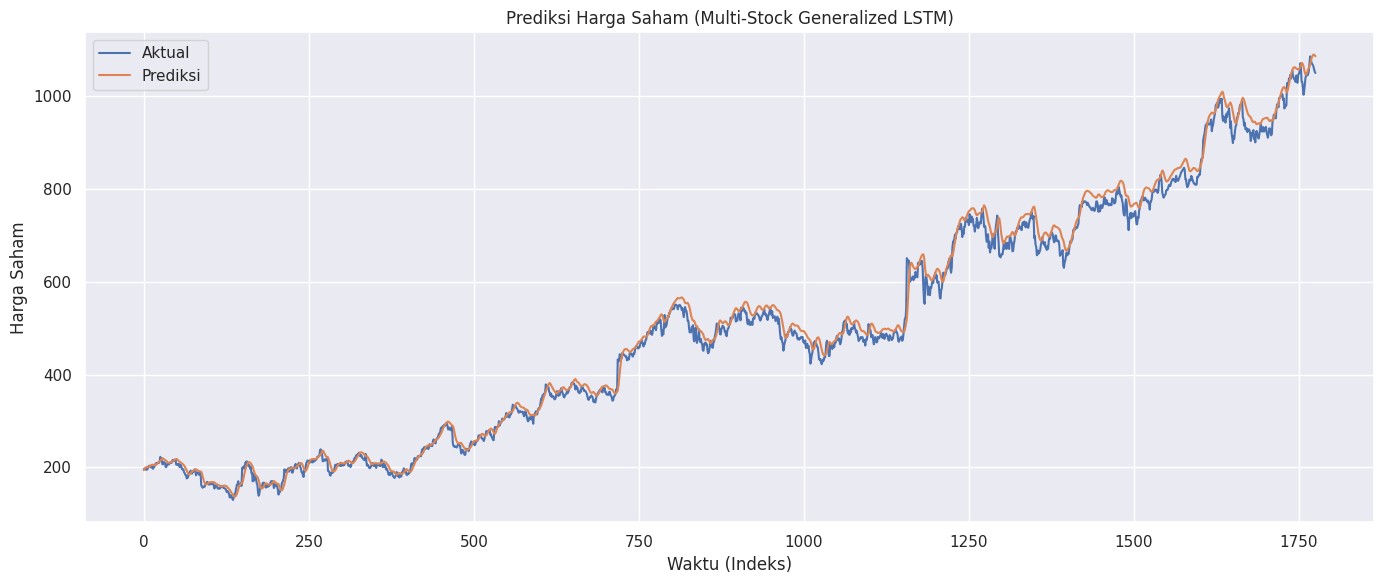

In [70]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Aktual')
plt.plot(y_pred_inv, label='Prediksi')
plt.title("Prediksi Harga Saham (Multi-Stock Generalized LSTM)")
plt.xlabel("Waktu (Indeks)")
plt.ylabel("Harga Saham")
plt.legend()
plt.tight_layout()
plt.show()


### Evaluasi Model

In [71]:
# Hitung RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# Hitung MAE
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Hitung R-squared
r2 = r2_score(y_test_inv, y_pred_inv)
print(f'R-squared (R2): {r2:.2f}')

# Hitung MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Root Mean Squared Error (RMSE): 20.50
Mean Absolute Error (MAE): 15.16
R-squared (R2): 0.99
Mean Absolute Percentage Error (MAPE): 3.31%


## RNN

### Import Library

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import seaborn as sns
sns.set()


### Load dan Siapkan Data

In [73]:
# Load data
df = pd.read_csv("all_stocks_2006-01-01_to_2018-01-01.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Pilih beberapa saham untuk generalisasi model
symbols = ['AAPL', 'MSFT', 'GOOGL']
data = df[df['Name'].isin(symbols)][['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name']]

### Preprocessing

In [74]:
# Fungsi untuk melakukan pra-pemrosesan pada data saham
def preprocess_stock(df_stock, sequence_length=60):
    features = ['Open', 'High', 'Low', 'Close', 'Volume'] #
    scaler = MinMaxScaler() #
    scaled = scaler.fit_transform(df_stock[features]) #

    x, y = [], []
    for i in range(sequence_length, len(scaled)):
        x.append(scaled[i-sequence_length:i]) #
        y.append(scaled[i, features.index('Close')]) # Target adalah harga 'Close' yang sudah diskalakan

    x, y = np.array(x), np.array(y) #
    return x, y, scaler

### Gabungkan Data dari Beberapa Saham

In [75]:
# Gabungkan data dari beberapa saham
x_total_list, y_total_list = [], []
dates_list = [] # Untuk menyimpan tanggal
sequence_length = 60

for sym in symbols:
    stock_data_sym = data[data['Name'] == sym].dropna()
    stock_data_sym = stock_data_sym.sort_values('Date').reset_index(drop=True)

    x_s, y_s, _ = preprocess_stock(stock_data_sym, sequence_length)

    x_total_list.append(x_s)
    y_total_list.append(y_s)

    # Ambil tanggal yang sesuai untuk nilai y_s
    dates_s = stock_data_sym['Date'].iloc[sequence_length : sequence_length + len(y_s)].tolist()
    dates_list.extend(dates_s)

x_total = np.concatenate(x_total_list, axis=0)
y_total = np.concatenate(y_total_list, axis=0)
all_dates_for_y = pd.to_datetime(pd.Series(dates_list))

print("Total sampel data:", x_total.shape[0])
print("Total tanggal untuk y:", len(all_dates_for_y))

Total sampel data: 8877
Total tanggal untuk y: 8877


### Split Train-Test

In [76]:
train_size = int(len(x_total) * 0.8) #
x_train, y_train = x_total[:train_size], y_total[:train_size] #
x_test, y_test = x_total[train_size:], y_total[train_size:] #

# Pembagian tanggal untuk set data uji
test_dates = all_dates_for_y[train_size:].reset_index(drop=True)

### Buat dan Latih Model RNN

In [77]:
# Membuat model RNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_rnn.add(Dropout(0.3))
model_rnn.add(SimpleRNN(units=32))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(units=1))

# Kompilasi model RNN
model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.summary()

# Melatih model RNN
history_rnn = model_rnn.fit(x_train, y_train,
                            epochs=30,
                            batch_size=64,
                            validation_data=(x_test, y_test),
                            verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 60, 64)         │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,617 (29.75 KB)

 Trainable params: 7,617 (29.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.1351 - val_loss: 5.1753e-04
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0210 - val_loss: 7.1524e-04
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0111 - val_loss: 4.6929e-04
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0076 - val_loss: 2.4504e-04
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0059 - val_loss: 1.9451e-04
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0044 - val_loss: 1.9638e-04
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0037 - val_loss: 4.5665e-04
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0032 - val_loss: 2.4553e-04
Epoch 9/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0031 - val_loss: 2.3789e-04
Epoch 10/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024 - val_loss: 3.2836e-04
Epoch 11/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0025 - val_loss: 4.3649e-

### Prediksi dan Invers Transformasi

In [78]:
# Melakukan prediksi dengan model RNN
y_pred_rnn = model_rnn.predict(x_test)

# Dummy scaler untuk inverse transform target 'Close'
dummy_scaler = MinMaxScaler()
dummy_scaler.fit(data[["Close"]])

# Transformasi invers pada hasil prediksi dan data uji aktual
y_pred_inv_rnn = dummy_scaler.inverse_transform(y_pred_rnn)
y_test_inv_rnn = dummy_scaler.inverse_transform(y_test.reshape(-1, 1))

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


### Visualisasi Hasil Prediksi

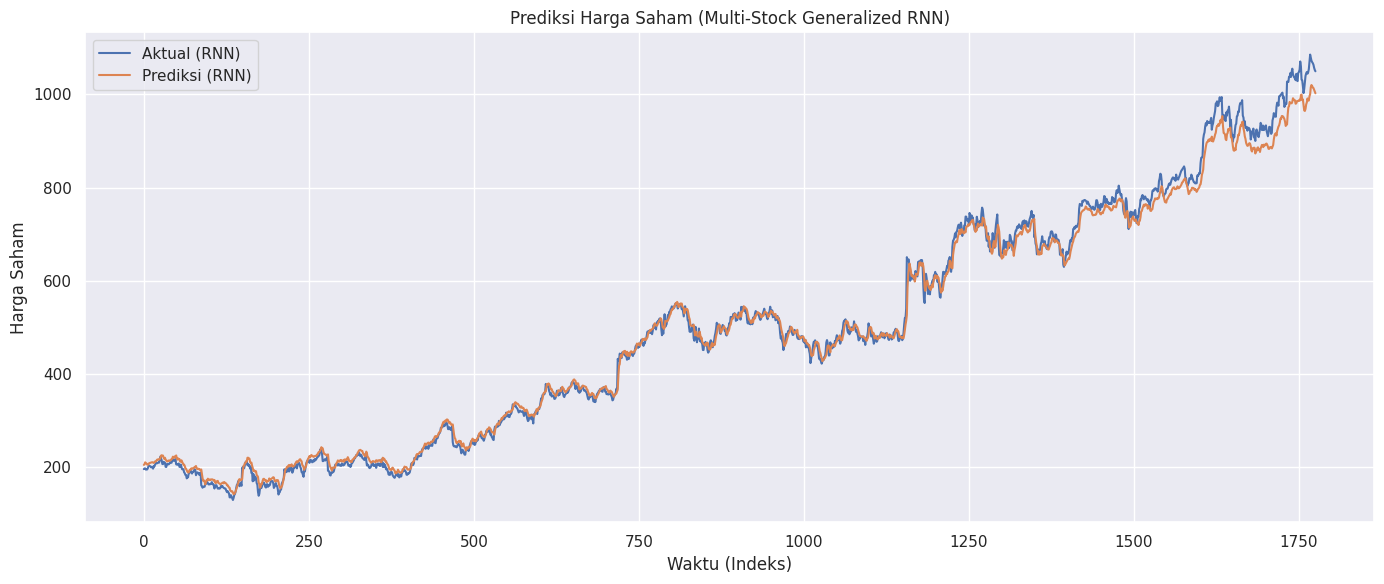

In [79]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv_rnn, label='Aktual (RNN)')
plt.plot(y_pred_inv_rnn, label='Prediksi (RNN)')
plt.title("Prediksi Harga Saham (Multi-Stock Generalized RNN)")
plt.xlabel("Waktu (Indeks)")
plt.ylabel("Harga Saham")
plt.legend()
plt.tight_layout()
plt.show()

### Evaluasi Model

In [80]:
# Hitung RMSE
rmse_rnn = np.sqrt(mean_squared_error(y_test_inv_rnn, y_pred_inv_rnn)) #
print(f'Root Mean Squared Error (RMSE) untuk RNN: {rmse_rnn:.2f}')

# Hitung MAE
mae_rnn = mean_absolute_error(y_test_inv_rnn, y_pred_inv_rnn) #
print(f'Mean Absolute Error (MAE) untuk RNN: {mae_rnn:.2f}')

# Hitung R-squared
r2_rnn = r2_score(y_test_inv_rnn, y_pred_inv_rnn) #
print(f'R-squared (R2) untuk RNN: {r2_rnn:.2f}')

# Hitung MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred) #
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100 #

mape_rnn = mean_absolute_percentage_error(y_test_inv_rnn, y_pred_inv_rnn) #
print(f'Mean Absolute Percentage Error (MAPE) untuk RNN: {mape_rnn:.2f}%')

Root Mean Squared Error (RMSE) untuk RNN: 19.58
Mean Absolute Error (MAE) untuk RNN: 13.84
R-squared (R2) untuk RNN: 0.99
Mean Absolute Percentage Error (MAPE) untuk RNN: 3.04%


## Perbandingan

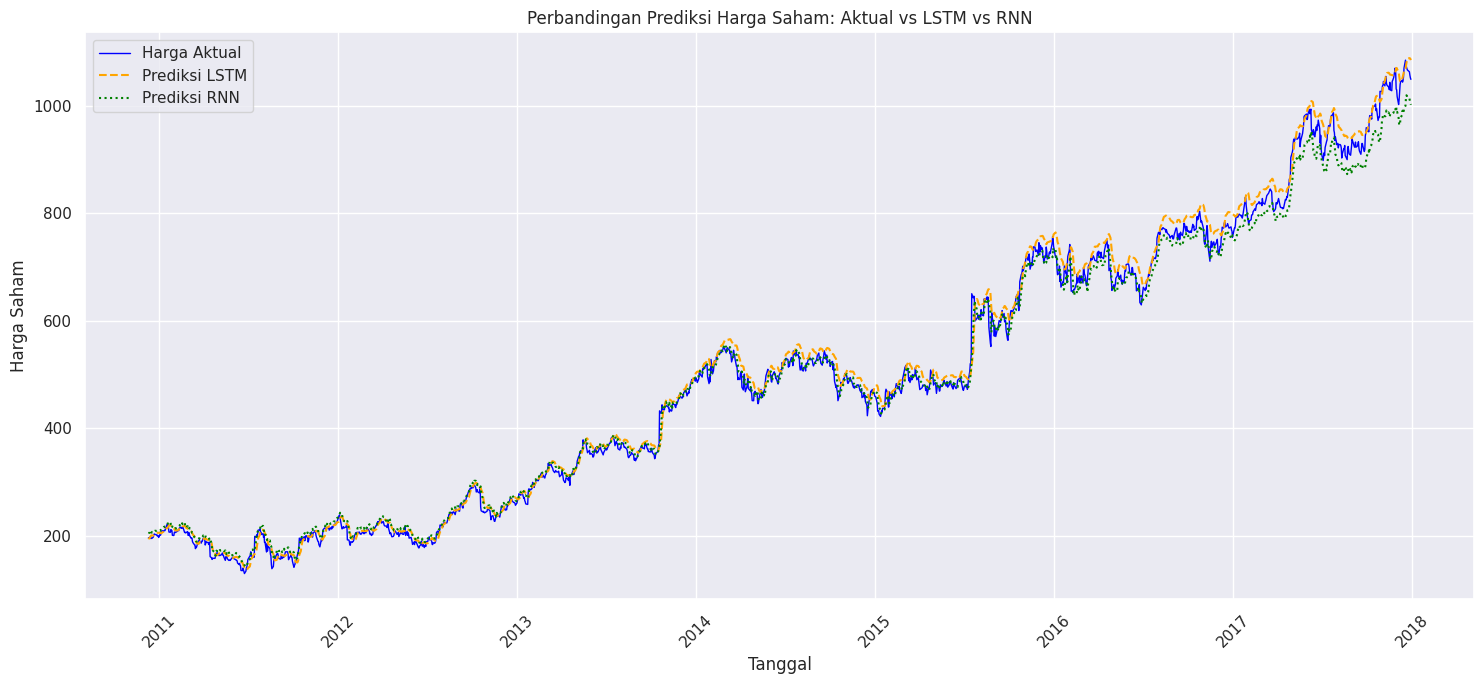


--- Tabel Perbandingan Metrik Evaluasi ---
  Model       RMSE        MAE  R-squared (R2)  MAPE (%)
0  LSTM  20.498566  15.155977        0.993478  3.312479
1   RNN  19.575402  13.843277        0.994052  3.037536


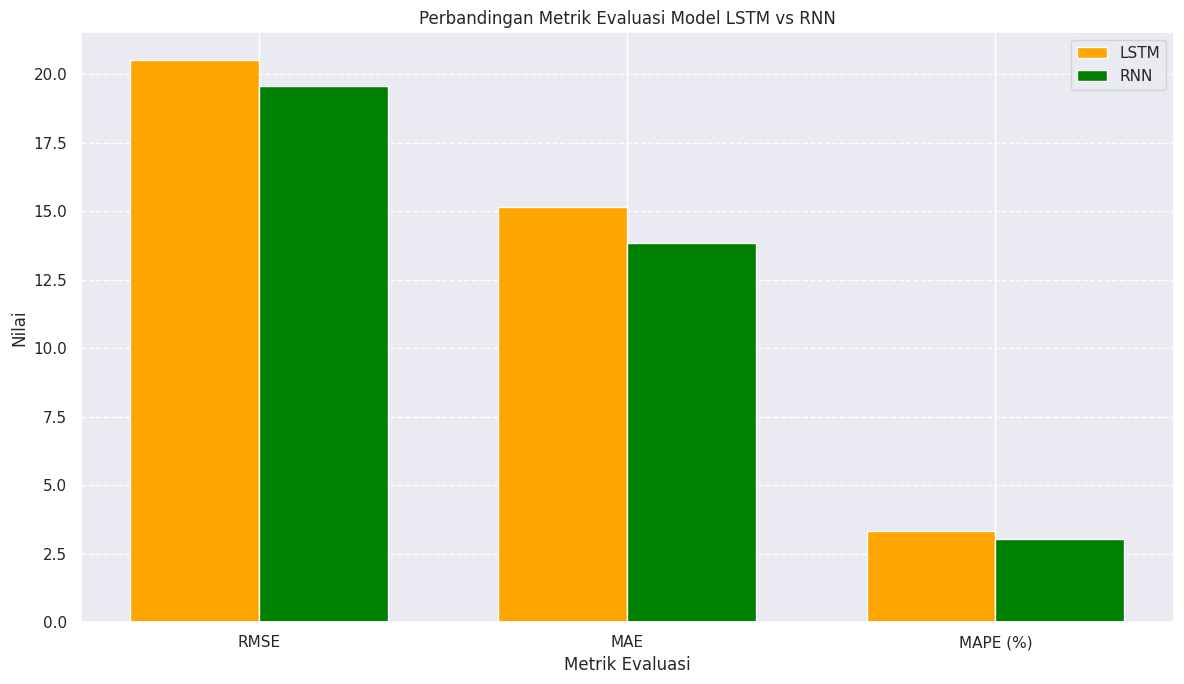

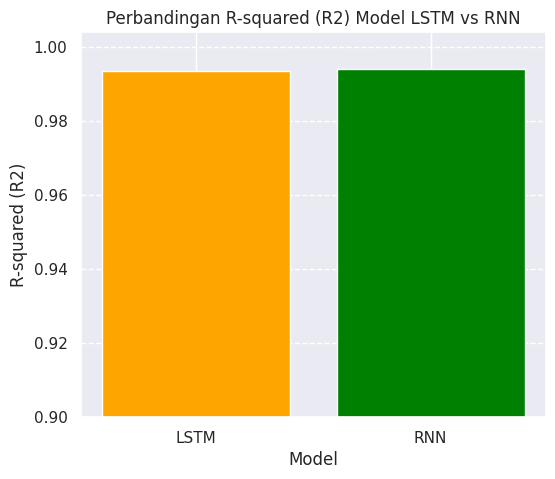

In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Visualisasi Perbandingan Prediksi Harga Saham dengan Sumbu-X Tanggal
plt.figure(figsize=(15, 7))
if len(test_dates) == len(y_test_inv_rnn):
    plt.plot(test_dates, y_test_inv_rnn, label='Harga Aktual', color='blue', linewidth=1)
    plt.plot(test_dates, y_pred_inv, label='Prediksi LSTM', color='orange', linestyle='--')
    plt.plot(test_dates, y_pred_inv_rnn, label='Prediksi RNN', color='green', linestyle=':')
    plt.xlabel('Tanggal')
else:
    print("Peringatan: Panjang test_dates tidak cocok. Menggunakan indeks untuk sumbu-x.")
    plt.plot(y_test_inv_rnn, label='Harga Aktual', color='blue', linewidth=1)
    plt.plot(y_pred_inv, label='Prediksi LSTM', color='orange', linestyle='--')
    plt.plot(y_pred_inv_rnn, label='Prediksi RNN', color='green', linestyle=':')
    plt.xlabel('Waktu (Indeks Data Uji)')

plt.title('Perbandingan Prediksi Harga Saham: Aktual vs LSTM vs RNN')
plt.ylabel('Harga Saham')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tabel Perbandingan Metrik Evaluasi (kode tetap sama)
data_metrik = {
    'Model': ['LSTM', 'RNN'],
    'RMSE': [rmse, rmse_rnn],
    'MAE': [mae, mae_rnn],
    'R-squared (R2)': [r2, r2_rnn],
    'MAPE (%)': [mape, mape_rnn]
}
df_metrik = pd.DataFrame(data_metrik)
print("\n--- Tabel Perbandingan Metrik Evaluasi ---")
print(df_metrik)

# 3. Bar Chart untuk Perbandingan Metrik (kode tetap sama)
metrics_to_plot = ['RMSE', 'MAE', 'MAPE (%)']
n_metrics = len(metrics_to_plot)
bar_width = 0.35
index = np.arange(n_metrics)

fig, ax = plt.subplots(figsize=(12, 7))
bar_lstm = ax.bar(index - bar_width/2, df_metrik[df_metrik['Model'] == 'LSTM'][metrics_to_plot].values.flatten(), bar_width, label='LSTM', color='orange')
bar_rnn = ax.bar(index + bar_width/2, df_metrik[df_metrik['Model'] == 'RNN'][metrics_to_plot].values.flatten(), bar_width, label='RNN', color='green')

ax.set_xlabel('Metrik Evaluasi')
ax.set_ylabel('Nilai')
ax.set_title('Perbandingan Metrik Evaluasi Model LSTM vs RNN')
ax.set_xticks(index)
ax.set_xticklabels(metrics_to_plot)
ax.legend()
plt.grid(True, axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Bar Chart untuk R-squared (R2)
plt.figure(figsize=(6, 5))
plt.bar(df_metrik['Model'], df_metrik['R-squared (R2)'], color=['orange', 'green'])
plt.xlabel('Model')
plt.ylabel('R-squared (R2)')
plt.title('Perbandingan R-squared (R2) Model LSTM vs RNN')
min_r2_val = 0.9 if df_metrik['R-squared (R2)'].empty else df_metrik['R-squared (R2)'].min() - 0.01
max_r2_val = 1.0 if df_metrik['R-squared (R2)'].empty else df_metrik['R-squared (R2)'].max() + 0.01
plt.ylim(min(0.9, min_r2_val), max(1.0, max_r2_val))
plt.grid(True, axis='y', linestyle='--')
plt.show()